In [1]:
!pip install tsai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 2.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.4 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd 
import numpy as np 
from collections import Counter 
import matplotlib.pyplot as plt
from tsai.all import *

In [3]:
class ArrayGenerator:
    import numpy as np
    
    dataset_categories = {
        1: "motor",
        2: "bearing",
        3: "flow",
        4: "lxc",
        5: "mixed",
        6: "coupling",
        7: "all",
        8: "status"
    }
    
    dataset_descriptions = {
        1: {"Faults classified": "AirGap, Electrical and SoftFoot problems", "Channels taken": "Motor channels only", "Labels array": "Binary"},
        2: {"Faults classified": "BearingFault, BearingWear, BearingLubrication", "Channels taken": "According to label", "Labels array": "Binary"},
        3: {"Faults classified": "Flow problem", "Channels taken": "Machine channels only", "Labels array": "Binary"},
        4: {"Faults classified": "LXC, XC, Losseness", "Channels taken": "All", "Labels array": "Binary"},
        5: {"Faults classified": "LXC, Unbalance, BaseProblems", "Channels taken": "All", "Labels array": "multiclass multilabel"},
        6: {"Faults classified": "Coupling problems", "Channels taken": "Drive end channels only", "Labels array": "Binary"},
        7: {"Faults classified": "All", "Channels taken": "All", "Labels array": "multiclass multilabel"},
        8: {"Faults classified": "Status", "Channels taken": "All", "Labels array": "multiclass"}
    }
    
    def separate_data(self, ts, labels, split_method):
        _, num_channels, num_points = ts.shape
        
        if split_method == "channel":
            new_ts = ts.reshape(-1, 1, num_points)
            new_labels = np.repeat(labels, repeats=num_channels, axis=0)
        
        elif split_method == "bearing":
            new_ts = ts.reshape(-1, 3, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 3, axis=0)
        
        elif split_method == "machine":
            new_ts = ts.reshape(-1, 6, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 6, axis=0)
        
        elif split_method == "None":  # Changed from None to "None"
            new_ts = ts
            new_labels = np.array(labels)
        
        else:
            raise Exception("Invalid split type: choose from [channel, bearing, machine, None]")
        
        return new_ts, new_labels
    
    def generate_dataset_array(self, dataset_category, ts, labels, split_method):
        if dataset_category == 1: 
            faults = ["AirGap", "SoftFoot", "ElectricalProblem"]
            new_labels = [1 if any(motor_fault in fault for fault in faults_list for motor_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, :6, :]

        elif dataset_category == 2:
            faults = ["BearingFault", "BearingWear", "BearingLubrication"]
            new_labels = np.zeros((len(labels), 2))
    
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    if any(bearing_fault == fault_name for bearing_fault in faults):
                        if fault_location == "motor":
                            new_labels[major_index][0] = 1
                        else:
                            new_labels[major_index][1] = 1
                            
            new_ts_1 = ts[:, :6, :]
            new_labels_1 = new_labels[:, 0]
    
            new_ts_2 = ts[:, 6:, :]
            new_labels_2 = new_labels[:, 1]
            
            new_labels = np.concatenate([new_labels_1, new_labels_2], axis=0)
            new_ts = np.concatenate([new_ts_1, new_ts_2], axis=0)

        elif dataset_category == 3:
            faults = ["Flow"]
            new_labels = [1 if any(flow_fault in fault for fault in faults_list for flow_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 6:, :]

        elif dataset_category == 4:
            faults = ["LXC", "Looseness", "XC"]
            new_labels = [1 if any(lxc_fault in fault for fault in faults_list for lxc_fault in faults) else 0 for faults_list in labels]
            new_ts = ts

        elif dataset_category == 5:
            faults_and_indices = {
                0: ["LXC", "Looseness", "XC"],
                1: ["BaseProblems"],
                2: ["Unbalance"]
            }

            new_labels = np.zeros((len(labels), 3))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_names in faults_and_indices.items():
                        if fault_name in fault_names:
                            new_labels[major_index][index] = 1
            new_ts = ts

        elif dataset_category == 6:
            faults = ["Coupling", "BeltProblem"]
            new_labels = [1 if any(coupling_fault in fault for fault in faults_list for coupling_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 3:9, :]

        elif dataset_category == 7:
            faults_and_indices = {
                0: ["AirGap", "SoftFoot", "ElectricalProblem"],
                1: ["BearingFault", "BearingWear", "BearingLubrication"],
                2: ["flow"],
                3: ["LXC", "Looseness", "XC"],
                4: ["BaseProblems"],
                5: ["Unbalance"],
                6: ["Coupling", "BeltProblem"]
            }

            new_labels = np.zeros((len(labels), 7))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_cluster in faults_and_indices.items():
                        if fault_name in fault_cluster:
                            new_labels[major_index][index] = 1

            new_ts = ts

        elif dataset_category == 8:
            if type(labels[0]) == list:
                raise Exception("Invalid labels for category 8")
            new_ts = ts
            new_labels = labels

        else:
            raise Exception("Invalid dataset category, choose from [1, 2, 3, 4, 5, 6, 7]")

        print(self.dataset_descriptions[dataset_category])
        return self.separate_data(ts=new_ts, labels=new_labels, split_method=split_method)
    
    def calculate_fft(self, signal):
        signal = signal * np.hanning(len(signal))  # Apply hanning window
        fft = np.fft.fft(signal)
        fft = np.abs(fft)  # Take absolute value
        fft = fft[: len(fft) // 2]  # Take the first half only
        return fft

    def apply_sliding_window(self, ts_3d, labels, window_size=1024, with_fft=False, overlap_pct=0.0):
        
        x_new = []
        y_new = []
    
        
        for ts, label in zip(ts_3d, labels):
            ts = ts[:, ~np.any(np.isnan(ts), axis=0)] #Remove columns with NaN values
            """np.isnan(ts) checks for NaN (Not a Number) values in the ts array.
                np.any(..., axis=0) checks if any of the values in each column is NaN.
                 ~ negates the boolean array, so ~np.any(...) keeps only the columns where there are no NaN values."""
            num_channels, signal_length = ts.shape #Get the number of channels and signal length
            overlap = int(window_size * overlap_pct)
            stride = window_size - overlap
            num_windows = (signal_length - window_size) // stride + 1
            
            
            
            if with_fft:
                fft_window_size = window_size if window_size % 2 == 0 else window_size + 1
                x_temp = np.zeros((num_windows, num_channels, window_size // 2))
            else:
                x_temp = np.zeros((num_windows, num_channels, window_size))

            y_temp = []

            for i in range(num_windows):
                start = i * stride
                end = start + window_size
                
                if with_fft:
                    x_temp[i] = np.apply_along_axis(self.calculate_fft, arr=ts[:, start:end], axis=1)
                else:
                    x_temp[i] = ts[:, start:end]
                    
                y_temp.append(label)

            x_new.append(x_temp)
            y_new.append(y_temp)

        x_new, y_new = np.concatenate(x_new), np.concatenate(y_new)

        return x_new, y_new


In [4]:
df = pd.read_pickle(r"/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle")
df.head(1)

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans,ts
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101-22-6144.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)","[[-0.01095184, -0.011836081, -0.012565245, -0.012270509, -0.012300278, -0.013320656, -0.013026895, -0.012533905, -0.013063409, -0.012450588, -0.011686881, -0.012133516, -0.011509651, -0.011013504, -0.01114404, -0.010445369, -0.009850427, -0.01007186, -0.009217497, -0.008727451, -0.008961891, -0.008416777, -0.007894184, -0.008172687, -0.008083154, -0.007089157, -0.006830435, -0.006774916, -0.005936872, -0.005677863, -0.005666965, -0.004578024, -0.004122706, -0.003228867, -0.001870759, -0.001284106, -0.000899825, 0.000474368, 0.000831867, 0.001056994, 0.002552633, 0.003245881, 0.002865068, 0..."


In [5]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])
X.shape, y.shape

((217, 12, 16384), (217,))

In [6]:
# Instantiate ArrayGenerator
array_gen = ArrayGenerator()

# Call generate_dataset_array method on the instance
X, y = array_gen.generate_dataset_array(dataset_category=1, ts=X, labels=y, split_method="channel")


{'Faults classified': 'AirGap, Electrical and SoftFoot problems', 'Channels taken': 'Motor channels only', 'Labels array': 'Binary'}


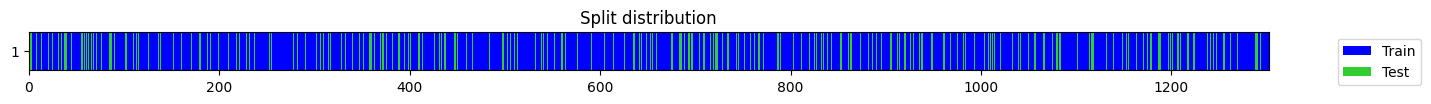

In [7]:
report_splits = get_splits(y, valid_size=0.2, shuffle=True)

In [8]:
X_train, y_train = X[report_splits[0]], y[report_splits[0]]
X_test, y_test = X[report_splits[1]], y[report_splits[1]]

In [9]:
array_gen = ArrayGenerator()
X_train, y_train = array_gen.apply_sliding_window(ts_3d=X_train, labels=y_train, window_size=1024, with_fft=False, overlap_pct=0.8)
X_test, y_test = array_gen.apply_sliding_window(ts_3d=X_test, labels=y_test, window_size=1024, with_fft=False, overlap_pct=0.0)


valid == train


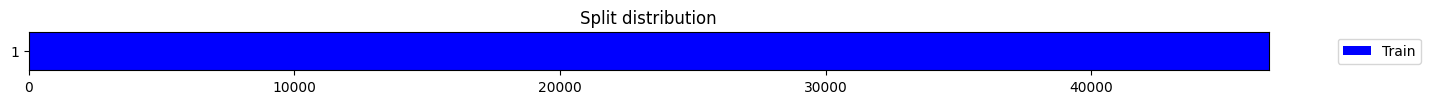

Counter({0: 35725, 1: 35725})

In [10]:
train_balance_splits = get_splits(y_train, valid_size=0, balance=True, strategy="oversample", shuffle=True)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
Counter(y_train)

In [11]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test]) 

In [12]:
tfms  = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[32,256])

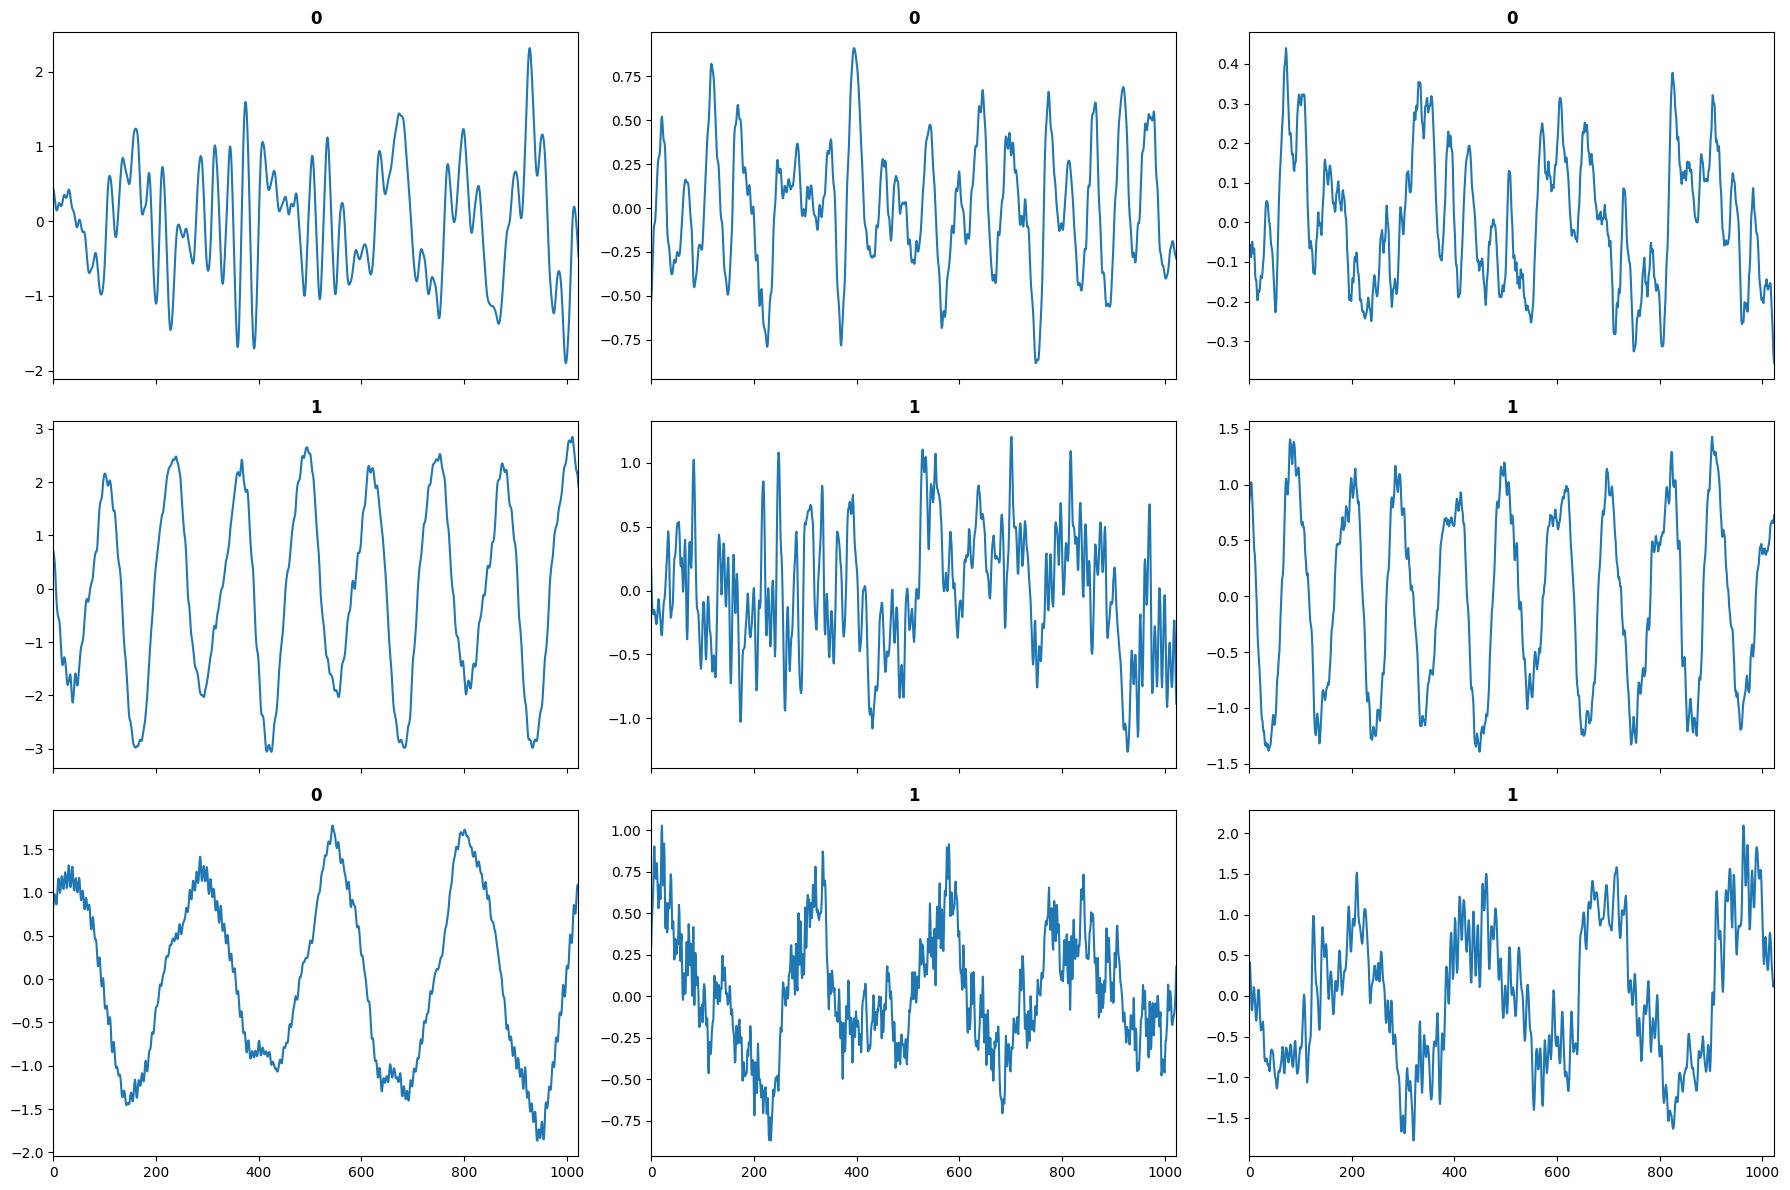

In [13]:
dls.show_batch(sharex=True) 

In [14]:
model = MLP(dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.630452,0.665782,0.570082,0.349823,0.793269,0.485532,0.643331,00:11
1,0.552588,0.587326,0.671721,0.422707,0.775641,0.547202,0.705827,00:11
2,0.502127,0.604739,0.671311,0.424320,0.799679,0.554444,0.713441,00:11
3,0.497244,0.586719,0.663115,0.418317,0.812500,0.552288,0.712142,00:11
4,0.485835,0.581970,0.667623,0.421495,0.804487,0.553168,0.712541,00:11
5,0.486200,0.581852,0.670082,0.423110,0.798077,0.553026,0.712089,00:11


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
5,0.4862,0.581852,0.670082,0.42311,0.798077,0.553026,0.712089


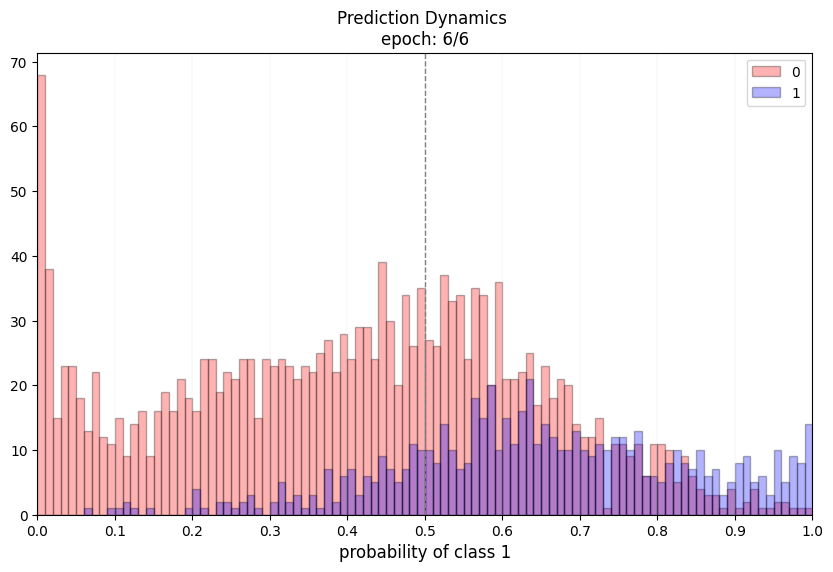

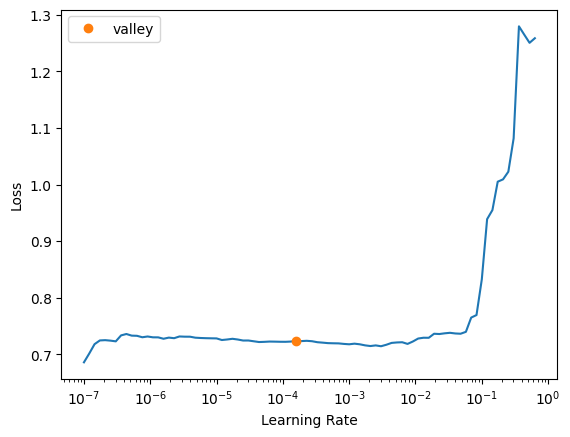

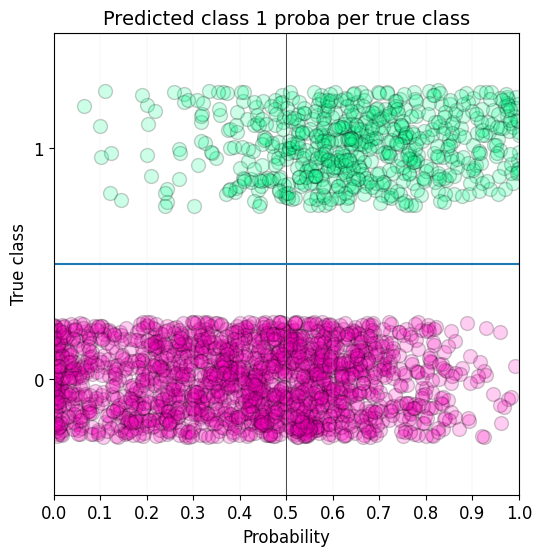

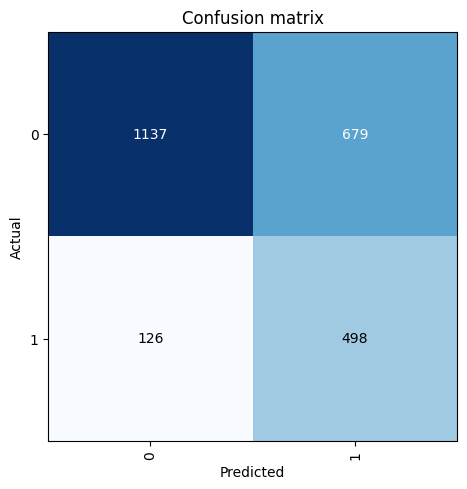

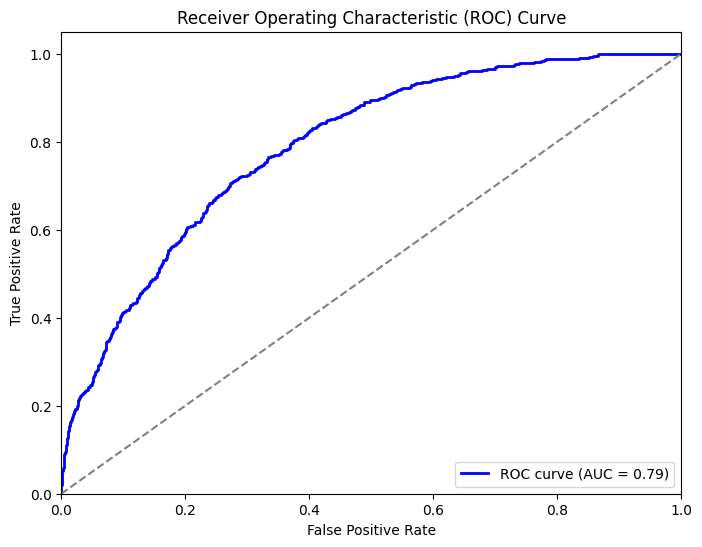

In [15]:
learn.fit_one_cycle(6, lr_max=learn.lr_find(), cbs=[PredictionDynamics()]) 
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
#Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [16]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 955.8 kB/s eta 0:00:000:00:01


[I 2024-05-12 01:04:46,010] A new study created in memory with name: no-name-b3eb0af0-e16c-4d14-8455-1d4689d52be9


  0%|          | 0/8 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.689233,0.736642,0.320492,0.266907,0.948718,0.416608,0.526672,00:11
1,0.663785,0.689293,0.505328,0.323012,0.852564,0.468516,0.619289,00:11
2,0.646504,0.672234,0.570082,0.350035,0.794872,0.486036,0.643857,00:12
3,0.638417,0.661732,0.591393,0.362767,0.790064,0.497226,0.656596,00:11
4,0.625210,0.651789,0.622131,0.382306,0.775641,0.512169,0.672512,00:11
5,0.615167,0.654755,0.609836,0.374233,0.782051,0.506224,0.666356,00:11
6,0.624606,0.652151,0.623361,0.384132,0.783654,0.515551,0.675968,00:11


[I 2024-05-12 01:06:08,857] Trial 0 finished with value: 0.6521506309509277 and parameters: {'hidden_size': 32, 'dropout_rate': 0.6055787322403078}. Best is trial 0 with value: 0.6521506309509277.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.570363,0.654374,0.640574,0.382106,0.657051,0.483206,0.645982,00:11
1,0.532240,0.612802,0.659016,0.410653,0.766026,0.534676,0.694136,00:11
2,0.489367,0.649584,0.671311,0.421930,0.770833,0.545351,0.703974,00:11
3,0.494002,0.563082,0.700820,0.450743,0.777244,0.570588,0.725902,00:11
4,0.466298,0.608980,0.725000,0.476142,0.751603,0.582971,0.733731,00:11
5,0.451030,0.542887,0.722951,0.473948,0.758013,0.583231,0.734458,00:12
6,0.457492,0.542951,0.724180,0.474923,0.743590,0.579638,0.730550,00:11


[I 2024-05-12 01:07:31,844] Trial 1 finished with value: 0.5429511666297913 and parameters: {'hidden_size': 64, 'dropout_rate': 0.7316401253501127}. Best is trial 1 with value: 0.5429511666297913.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.567451,0.650265,0.668852,0.420000,0.774038,0.544532,0.703374,00:11
1,0.530243,0.634362,0.647951,0.405622,0.809295,0.540396,0.700903,00:11
2,0.521745,0.600643,0.722131,0.471092,0.705128,0.564827,0.716551,00:11
3,0.484562,0.619379,0.690984,0.440147,0.766026,0.559064,0.715612,00:11
4,0.466746,0.569755,0.706967,0.455172,0.740385,0.563758,0.717935,00:11
5,0.453734,0.560532,0.694672,0.443405,0.759615,0.559953,0.715986,00:11
6,0.470907,0.546979,0.717213,0.466599,0.738782,0.571960,0.724292,00:11


[I 2024-05-12 01:08:53,896] Trial 2 finished with value: 0.5469791889190674 and parameters: {'hidden_size': 16, 'dropout_rate': 0.05794645213019656}. Best is trial 1 with value: 0.5429511666297913.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.587724,0.630597,0.669262,0.415512,0.721154,0.527241,0.686293,00:11
1,0.551468,0.592185,0.671311,0.423276,0.786859,0.550448,0.709233,00:11
2,0.511707,0.580419,0.700820,0.447106,0.717949,0.551046,0.706441,00:11
3,0.480369,0.612077,0.681967,0.431655,0.769231,0.552995,0.710607,00:11
4,0.458764,0.564903,0.701639,0.452899,0.801282,0.578704,0.734341,00:11
5,0.467508,0.529566,0.720082,0.470292,0.748397,0.577613,0.729375,00:11
6,0.445142,0.535875,0.719262,0.470010,0.766026,0.582572,0.734610,00:11


[I 2024-05-12 01:10:16,091] Trial 3 finished with value: 0.5358746647834778 and parameters: {'hidden_size': 16, 'dropout_rate': 0.0690168014846495}. Best is trial 3 with value: 0.5358746647834778.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.621109,0.649140,0.677869,0.424581,0.730769,0.537102,0.695230,00:11
1,0.515337,0.597686,0.672951,0.426020,0.802885,0.556667,0.715594,00:12
2,0.509560,0.581554,0.664344,0.419087,0.809295,0.552214,0.711916,00:11
3,0.492143,0.598806,0.664754,0.419167,0.806090,0.551535,0.711140,00:11
4,0.459674,0.553295,0.696721,0.447273,0.788462,0.570766,0.726830,00:11
5,0.470740,0.547190,0.698770,0.449500,0.791667,0.573418,0.729258,00:11
6,0.457232,0.556134,0.696311,0.447907,0.806090,0.575844,0.732340,00:11


[I 2024-05-12 01:11:38,838] Trial 4 finished with value: 0.556133508682251 and parameters: {'hidden_size': 128, 'dropout_rate': 0.20398748817353995}. Best is trial 3 with value: 0.5358746647834778.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.643764,0.658513,0.629098,0.388580,0.785256,0.519894,0.680348,00:11
1,0.546555,0.639211,0.632377,0.397906,0.852564,0.542580,0.704641,00:11
2,0.526991,0.609737,0.650820,0.412037,0.855769,0.556250,0.718083,00:11
3,0.508605,0.585404,0.679918,0.434746,0.838141,0.572523,0.731846,00:11
4,0.492859,0.594028,0.665164,0.419247,0.802885,0.550852,0.710363,00:11
5,0.497053,0.586968,0.672951,0.428571,0.836538,0.566775,0.726639,00:11
6,0.475511,0.597118,0.660656,0.417609,0.828526,0.555317,0.715750,00:11


[I 2024-05-12 01:13:00,895] Trial 5 finished with value: 0.5971182584762573 and parameters: {'hidden_size': 128, 'dropout_rate': 0.623286802837725}. Best is trial 3 with value: 0.5358746647834778.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.591056,0.627528,0.645902,0.398990,0.759615,0.523179,0.683222,00:11
1,0.544209,0.647283,0.642213,0.395816,0.758013,0.520066,0.680218,00:11
2,0.515657,0.599693,0.680328,0.434891,0.834936,0.571899,0.731069,00:11
3,0.481060,0.559349,0.712705,0.463985,0.794872,0.585942,0.739672,00:11
4,0.475128,0.548218,0.707377,0.459016,0.807692,0.585366,0.740300,00:11
5,0.441325,0.550279,0.706967,0.459046,0.817308,0.587896,0.743180,00:11
6,0.452738,0.545363,0.707787,0.459801,0.815705,0.588099,0.743205,00:11


[I 2024-05-12 01:14:23,159] Trial 6 finished with value: 0.5453628301620483 and parameters: {'hidden_size': 128, 'dropout_rate': 0.8907249335520409}. Best is trial 3 with value: 0.5358746647834778.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.587133,0.662102,0.629508,0.386731,0.766026,0.513978,0.674312,00:11
1,0.530805,0.587163,0.697131,0.448980,0.810897,0.577955,0.734469,00:11
2,0.521744,0.574982,0.702049,0.449658,0.737179,0.558591,0.713579,00:11
3,0.485306,0.555634,0.704098,0.453422,0.764423,0.569212,0.723897,00:11
4,0.472661,0.560434,0.706148,0.454810,0.750000,0.566243,0.720540,00:11
5,0.445604,0.551588,0.717623,0.466938,0.735577,0.571251,0.723515,00:11
6,0.448058,0.545196,0.718443,0.468594,0.753205,0.577750,0.729851,00:11


[I 2024-05-12 01:15:45,104] Trial 7 finished with value: 0.5451964139938354 and parameters: {'hidden_size': 128, 'dropout_rate': 0.5167018415569317}. Best is trial 3 with value: 0.5358746647834778.


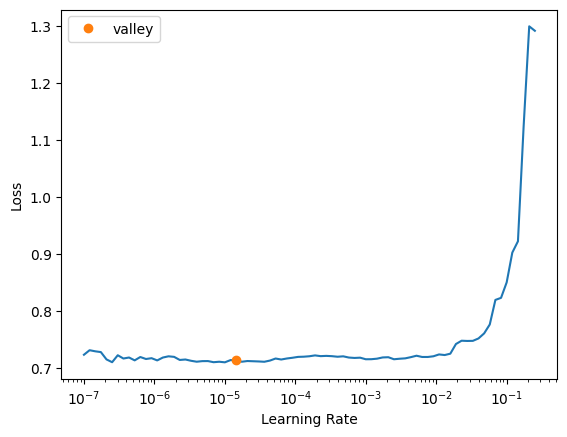

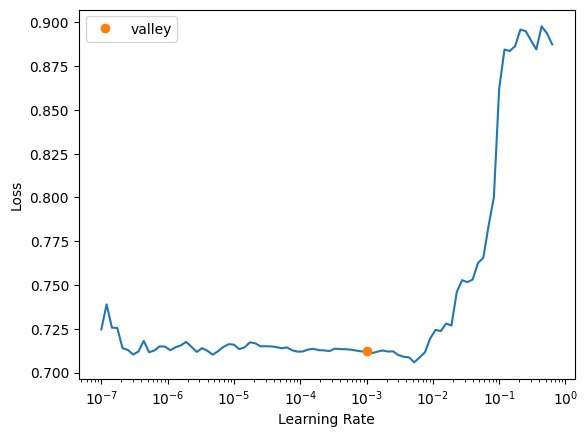

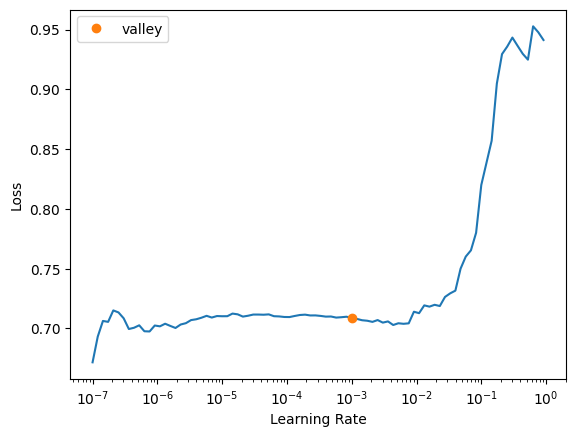

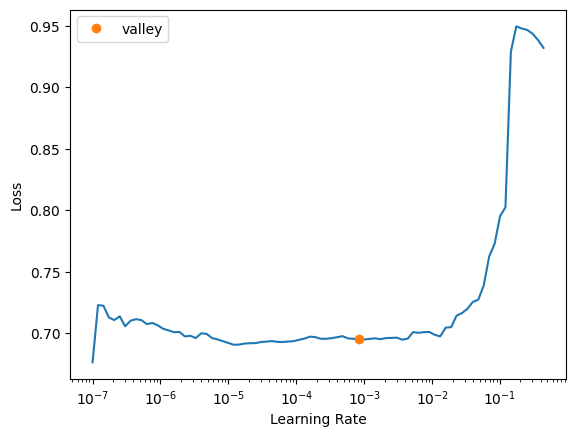

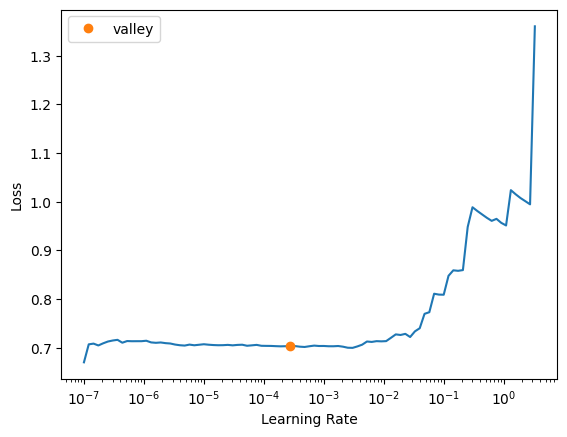

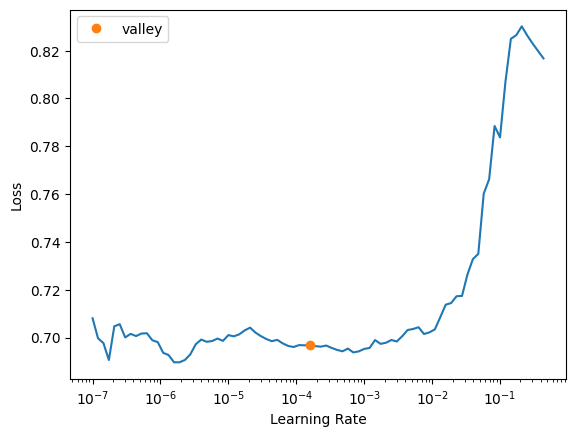

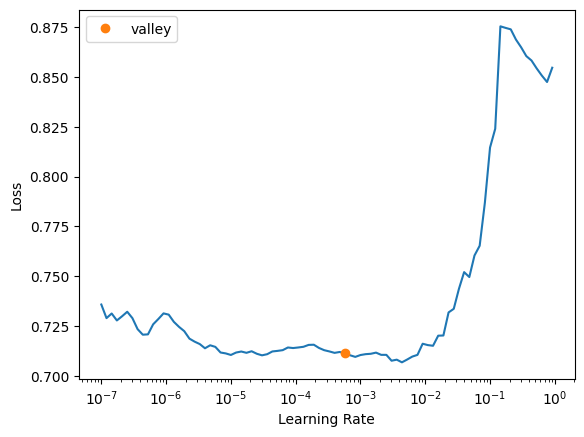

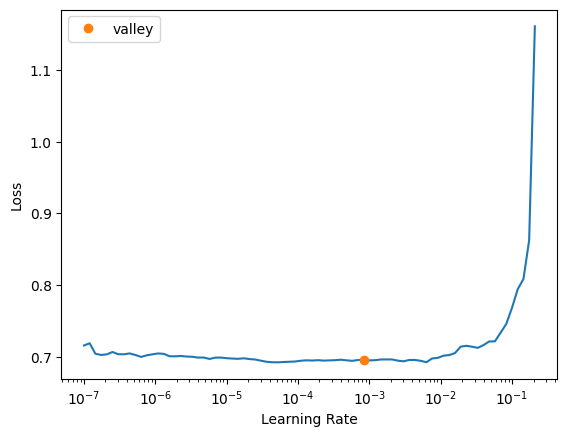

In [17]:
from fastai.callback.all import EarlyStoppingCallback
import optuna
from optuna.integration import FastAIPruningCallback
import optuna.integration

num_epochs = 7
num_optuna_trials = 8

# Get the input shape from the training data
seq_len = X_train.shape[-1]

def objective(trial: optuna.Trial):
    # Define search space here.
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    model = MLP(dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True)
    learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()])
    learn.fit_one_cycle(num_epochs, lr_max=learn.lr_find(), cbs=[EarlyStoppingCallback(patience=7)])

    # Return the validation loss - learn.recorder.values returns [[train_loss, valid_loss, metrics...]]
    return learn.recorder.values[-1][1]

study = optuna.create_study(
    direction="minimize", pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=True)


In [18]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  8
Best trial:
  Value:  0.5358746647834778
  Params: 
    hidden_size: 16
    dropout_rate: 0.0690168014846495


In [19]:
from tsai.all import *
all_arch_names

['FCN',
 'FCNPlus',
 'InceptionTime',
 'InceptionTimePlus',
 'InCoordTime',
 'XCoordTime',
 'InceptionTimePlus17x17',
 'InceptionTimePlus32x32',
 'InceptionTimePlus47x47',
 'InceptionTimePlus62x62',
 'InceptionTimeXLPlus',
 'MultiInceptionTimePlus',
 'MiniRocketClassifier',
 'MiniRocket',
 'MiniRocketRegressor',
 'MiniRocketVotingClassifier',
 'MiniRocketVotingRegressor',
 'MiniRocket',
 'MiniRocketPlus',
 'MultiRocket',
 'MultiRocketPlus',
 'InceptionRocketPlus',
 'MLP',
 'gMLP',
 'MultiInputNet',
 'OmniScaleCNN',
 'RNN',
 'LSTM',
 'GRU',
 'RNNPlus',
 'LSTMPlus',
 'GRUPlus',
 'RNN_FCN',
 'LSTM_FCN',
 'GRU_FCN',
 'MRNN_FCN',
 'MLSTM_FCN',
 'MGRU_FCN',
 'RNN_FCNPlus',
 'LSTM_FCNPlus',
 'GRU_FCNPlus',
 'MRNN_FCNPlus',
 'MLSTM_FCNPlus',
 'MGRU_FCNPlus',
 'ROCKET',
 'RocketClassifier',
 'RocketRegressor',
 'ResCNN',
 'ResNet',
 'ResNetPlus',
 'TCN',
 'TSPerceiver',
 'TST',
 'TSTPlus',
 'MultiTSTPlus',
 'TSiT',
 'TSiTPlus',
 'TabFusionTransformer',
 'TSTabFusionTransformer',
 'TabModel',
 '